In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import adjusted_mutual_info_score as AMI

from scipy import sparse
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (7,7)
import seaborn as sns
from scipy import sparse
# import muon as mu
# Import a module with ATAC-seq-related functions
# from muon import atac as ac
sc.settings.verbosity =0

In [2]:
import episcanpy as epi

In [3]:
sample_color_dic = {'lib_09': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'lib_10': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'lib_15': (1.0, 0.4980392156862745, 0.054901960784313725),
 'lib_23': (1.0, 0.7333333333333333, 0.47058823529411764),
 'lib_29': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'lib_34': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'lib_36': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'lib_38': (1.0, 0.596078431372549, 0.5882352941176471),
 'lib_51': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'lib_54': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 'lib_55': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'lib_56': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'lib_57': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)}

def comparison_heatmap(adata, key1, key2, label_1=None, label_2=None, cmap = 'Reds', annot = True, figsize=(7,7)):
    if label_1==None:
        label_1=key1
    if label_2==None:
        label_2=key2
    expected_df = adata.obs[[key1,key2]].groupby(by=[key2,key1]).size().reset_index(name = 'count')
    counts = np.array(expected_df['count'].tolist())
    df = pd.DataFrame(counts.reshape(((len(adata.obs[key2].cat.categories),len(adata.obs[key1].cat.categories)))), index = expected_df[key2].unique(), columns = expected_df[key1].unique())
    if annot ==True:
        annot_ = df.astype(int)
        sc.settings.set_figure_params(figsize=figsize, color_map='gist_earth')
    else:
        annot_=None
        sc.settings.set_figure_params(figsize=figsize, color_map='gist_earth')
    s = sns.heatmap(df/np.sum(df,axis = 0), cbar_kws={'label': '% cell shared between annotations'}, cmap=cmap, vmax=1, vmin=0, annot = annot_,  fmt='.7g')
    s.set_ylabel(label_2, fontsize=12)
    s.set_xlabel(label_1, fontsize = 12)
    return df

def n_cells_histogram(adata, sample_key='sample', sample_color_dic = sample_color_dic):
    df = pd.DataFrame(adata.obs[sample_key].value_counts().index, index = adata.obs[sample_key].value_counts().index  , columns =[ sample_key ])
    df['n_cells'] = adata.obs[sample_key].value_counts().values.astype(int)
    df.reindex(index=np.argsort(df['n_cells']).index.tolist()[::-1]).plot(kind='bar', x = sample_key, y ='n_cells', color = [sample_color_dic[i] for i in np.argsort(df['n_cells']).index.tolist()[::-1]], title = 'Total nº of Cells' )

In [4]:
palette_ = { 'PT':'#ff9896',
 'PT_VCAM1':'#c5b0d5',
 'TL':'#279e68',
 'TAL':'#c49c94',
 'DCT1':'#ff7f0e',
 'CNT':'#1f77b4',
 'PC':'#aec7e8',
 'ENDO':'#d62728',
 'MES':'#17becf',
 'FIB':'#aa40fc',
 'ICA':'#8c564b',
 'ICB':'#e377c2',
 'PODO':'#98df8a',
 'PEC':'#ffbb78',
 'LEUK':'#b5bd61',
          }


In [5]:
palette = {'CNT':'#1f77b4',
 'DCT1':'#ff7f0e',
 'DCT2':'#279e68',
 'TL':'#279e68',
 'DCT':'#279e68',
 'ENDO':'#d62728',
 'FIB':'#aa40fc',
 'ICA':'#8c564b',
 'ICB':'#e377c2',
 'LEUK':'#b5bd61',
 'MES_FIB':'#17becf',
 'MES':'#17becf',
 'PC':'#aec7e8',
 'PEC':'#ffbb78',
 'PODO':'#98df8a',
 'PT':'#ff9896',
 'PT_VCAM1':'#c5b0d5',
 'TAL':'#c49c94',
 'Unclassified':'#808080',
 'Unknown':'#000000',
 'Low_Quality_RNA':'#808080'}

In [6]:
markers_dict = { 'PT': ['LRP2', 'CUBN', 'SLC13A1','SLC5A12','SLC22A7','SLC22A6'],
                 'PT_VCAM1': ['ITGB8', 'DCDC2', 'TPM1','HAVCR1','KIF26B','ACSM3','DLGAP1','CDH6'],
                 'TL': ['CRYAB', 'TACSTD2', 'SLC44A5', 'KLRG2', 'COL26A1', 'BOC'],
                 'TAL': ['CASR', 'SLC12A1', 'UMOD'],
                 'DCT1': ['SLC12A3','CNNM2', 'FGF13', 'KLHL3', 'TRPM6'],
                 'CNT': ['SLC8A1', 'SCN2A', 'HSD11B2', 'CALB1'],
                 'PC': ['GATA3', 'AQP2', 'AQP3'],
                 'ENDO': ['CD34', 'PECAM1', 'PTPRB', 'MEIS2', 'FLT1', 'EMCN'],
                 'MES':['PIP5K1B','ROBO1','DAAM2', 'PHTF2', 'POSTN'],
                 'FIB':['COL1A1', 'COL1A2', 'C7', 'NEGR1', 'FBLN5', 'DCN', 'CDH11'],
                 'ICA': ['SLC4A1', 'SLC26A7', 'CLNK'],
                 'ICB': ['SLC4A9', 'SLC35F3', 'SLC26A4', 'INSRR','TLDC2'],
                 'PODO': ['PTPRQ', 'WT1', 'NPHS2','CLIC5', 'PODXL'],
                 'PEC': ['CLDN1', 'VCAM1', 'CFH', 'RBFOX1', 'ALDH1A2'],
                 'LEUK': ['PTPRC','PRKCB','ARHGAP15','MS4A1','CD96'],}

In [7]:
markers_dict_ = { 'Proximal Tubule Cell': ['LRP2', 'CUBN', 'SLC13A1','SLC5A12','SLC22A7','SLC22A6'],
                 'Adaptative Proximal Tubule Cell': ['ITGB8', 'DCDC2', 'TPM1','HAVCR1','KIF26B','ACSM3','DLGAP1','CDH6'],
                 'Thin Limb Cell': ['CRYAB', 'TACSTD2', 'SLC44A5', 'KLRG2', 'COL26A1', 'BOC'],
                 'Thick Ascending Limb Cell': ['CASR', 'SLC12A1', 'UMOD'],
                 'Distal Convoluted Tubule Cell': ['SLC12A3','CNNM2', 'FGF13', 'KLHL3', 'LHX1', 'TRPM6'],
                 'Connecting Tubule': ['SLC8A1', 'SCN2A', 'HSD11B2', 'CALB1'],
                 'Principal Cell': ['GATA3', 'AQP2', 'AQP3'],
                 'Endothelial Cell': ['CD34', 'PECAM1', 'PTPRB', 'MEIS2', 'FLT1', 'EMCN'],
                 'Mesenglial':['PIP5K1B','ROBO1','DAAM2', 'PHTF2', 'POSTN'],
                 'Fibroblast': ['COL1A1', 'COL1A2', 'C7', 'NEGR1', 'FBLN5', 'DCN', 'CDH11'],
                 'Intercalated Cell A': ['SLC4A1', 'SLC26A7', 'CLNK'],
                 'Intercalated Cell B': ['SLC4A9', 'SLC35F3', 'SLC26A4', 'INSRR','TLDC2'],
                 'Podocyte': ['PTPRQ', 'WT1', 'NPHS2','CLIC5', 'PODXL'],
                 'Parietal Epithelial Cell': ['CLDN1', 'VCAM1', 'CFH', 'RBFOX1', 'ALDH1A2'],
                 'Immune Cells': ['PTPRC','PRKCB','ARHGAP15','MS4A1','CD96'],}

# LOAD DATA TO INTEGRATE

In [8]:
adata = sc.read('objects/Integration_2ndQC_metadata.h5ad')

In [9]:
adata.X = adata.layers['counts'].copy()

In [10]:
adata.obs['sample'].unique()

['lib_55', 'lib_09', 'lib_16', 'lib_420', 'lib_20', ..., 'lib_57', 'lib_29', 'lib_36', 'lib_68', 'lib_49']
Length: 20
Categories (20, object): ['lib_03', 'lib_09', 'lib_10', 'lib_15', ..., 'lib_57', 'lib_68', 'lib_420', 'lib_776']

In [11]:
adata.raw = adata

In [22]:
adata.var['mt_rb'] = adata.var_names.str.startswith(("MT-","RPS", "RPL"))
adata.var['mt'] = adata.var_names.str.startswith(("MT-"))
adata.var['rb'] = adata.var_names.str.startswith(("RPS", "RPL"))

In [23]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt_rb','mt','rb'], percent_top=None, log1p=False, inplace=True)

# Removing DOUBLETS SCORED by tools and UNCLASSIFIED cells by LABEL TRANSFER

In [12]:
adata

AnnData object with n_obs × n_vars = 179290 × 38224
    obs: 'sample', 'batch', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Deepscore_external', 'Doublet_Detection_doublets_scRNA', 'Doublet_Detection_doublets_score_scRNA', 'Doublet_Detection_doublets_scRNA5p', 'Doublet_Detection_doublets_score_scRNA5p', 'AMULET_doublets', 'AMULET_pval', 'AMULET_qval', 'Doublet_Detection_doublets_snRNA', 'Doublet_Detection_doublets_score_snRNA'
    uns: 'batch_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [13]:
adata.obs.loc[adata[~adata.obs['batch'].isin(['scRNA'])].obs.index,'Doublet_Detection_doublets_scRNA'] = np.nan
adata.obs.loc[adata[~adata.obs['batch'].isin(['scRNA'])].obs.index,'Doublet_Detection_doublets_score_scRNA'] = np.nan

In [14]:
adata.obs.loc[adata[~adata.obs['batch'].isin(['scRNA5p'])].obs.index,'Doublet_Detection_doublets_scRNA5p'] = np.nan
adata.obs.loc[adata[~adata.obs['batch'].isin(['scRNA5p'])].obs.index,'Doublet_Detection_doublets_score_scRNA5p'] = np.nan

In [15]:
adata.obs['Doublet_Detection_doublets_scRNA'] = (adata.obs['Doublet_Detection_doublets_scRNA'] == 1).astype('category')
adata.obs['Doublet_Detection_doublets_snRNA'] = (adata.obs['Doublet_Detection_doublets_snRNA'] == 1).astype('category')
adata.obs['Doublet_Detection_doublets_scRNA5p'] = (adata.obs['Doublet_Detection_doublets_scRNA5p'] == 1).astype('category')

In [16]:
adata.obs['Doublet_Detection_doublets_scRNA5p']

AAAGAACAGGTAAAGG-1-0-scRNA      False
AAAGTCCCAATCGAAA-1-0-scRNA      False
AACAAGAAGACCTTTG-1-0-scRNA      False
AACCAACGTATCCCTC-1-0-scRNA      False
AAGACTCAGGTAAACT-1-0-scRNA      False
                                ...  
TTTCCTCTCGGAAACG-1-3-scRNA5p    False
TTTGCGCAGTGGCACA-1-3-scRNA5p    False
TTTGGTTCAATCCGAT-1-3-scRNA5p    False
TTTGGTTTCAAAGTAG-1-3-scRNA5p    False
TTTGTCAGTCACAAGG-1-3-scRNA5p    False
Name: Doublet_Detection_doublets_scRNA5p, Length: 179290, dtype: category
Categories (1, bool): [False]

In [17]:
adata.obs['1-AMULET_qval'] = 1- adata.obs['AMULET_qval'] 

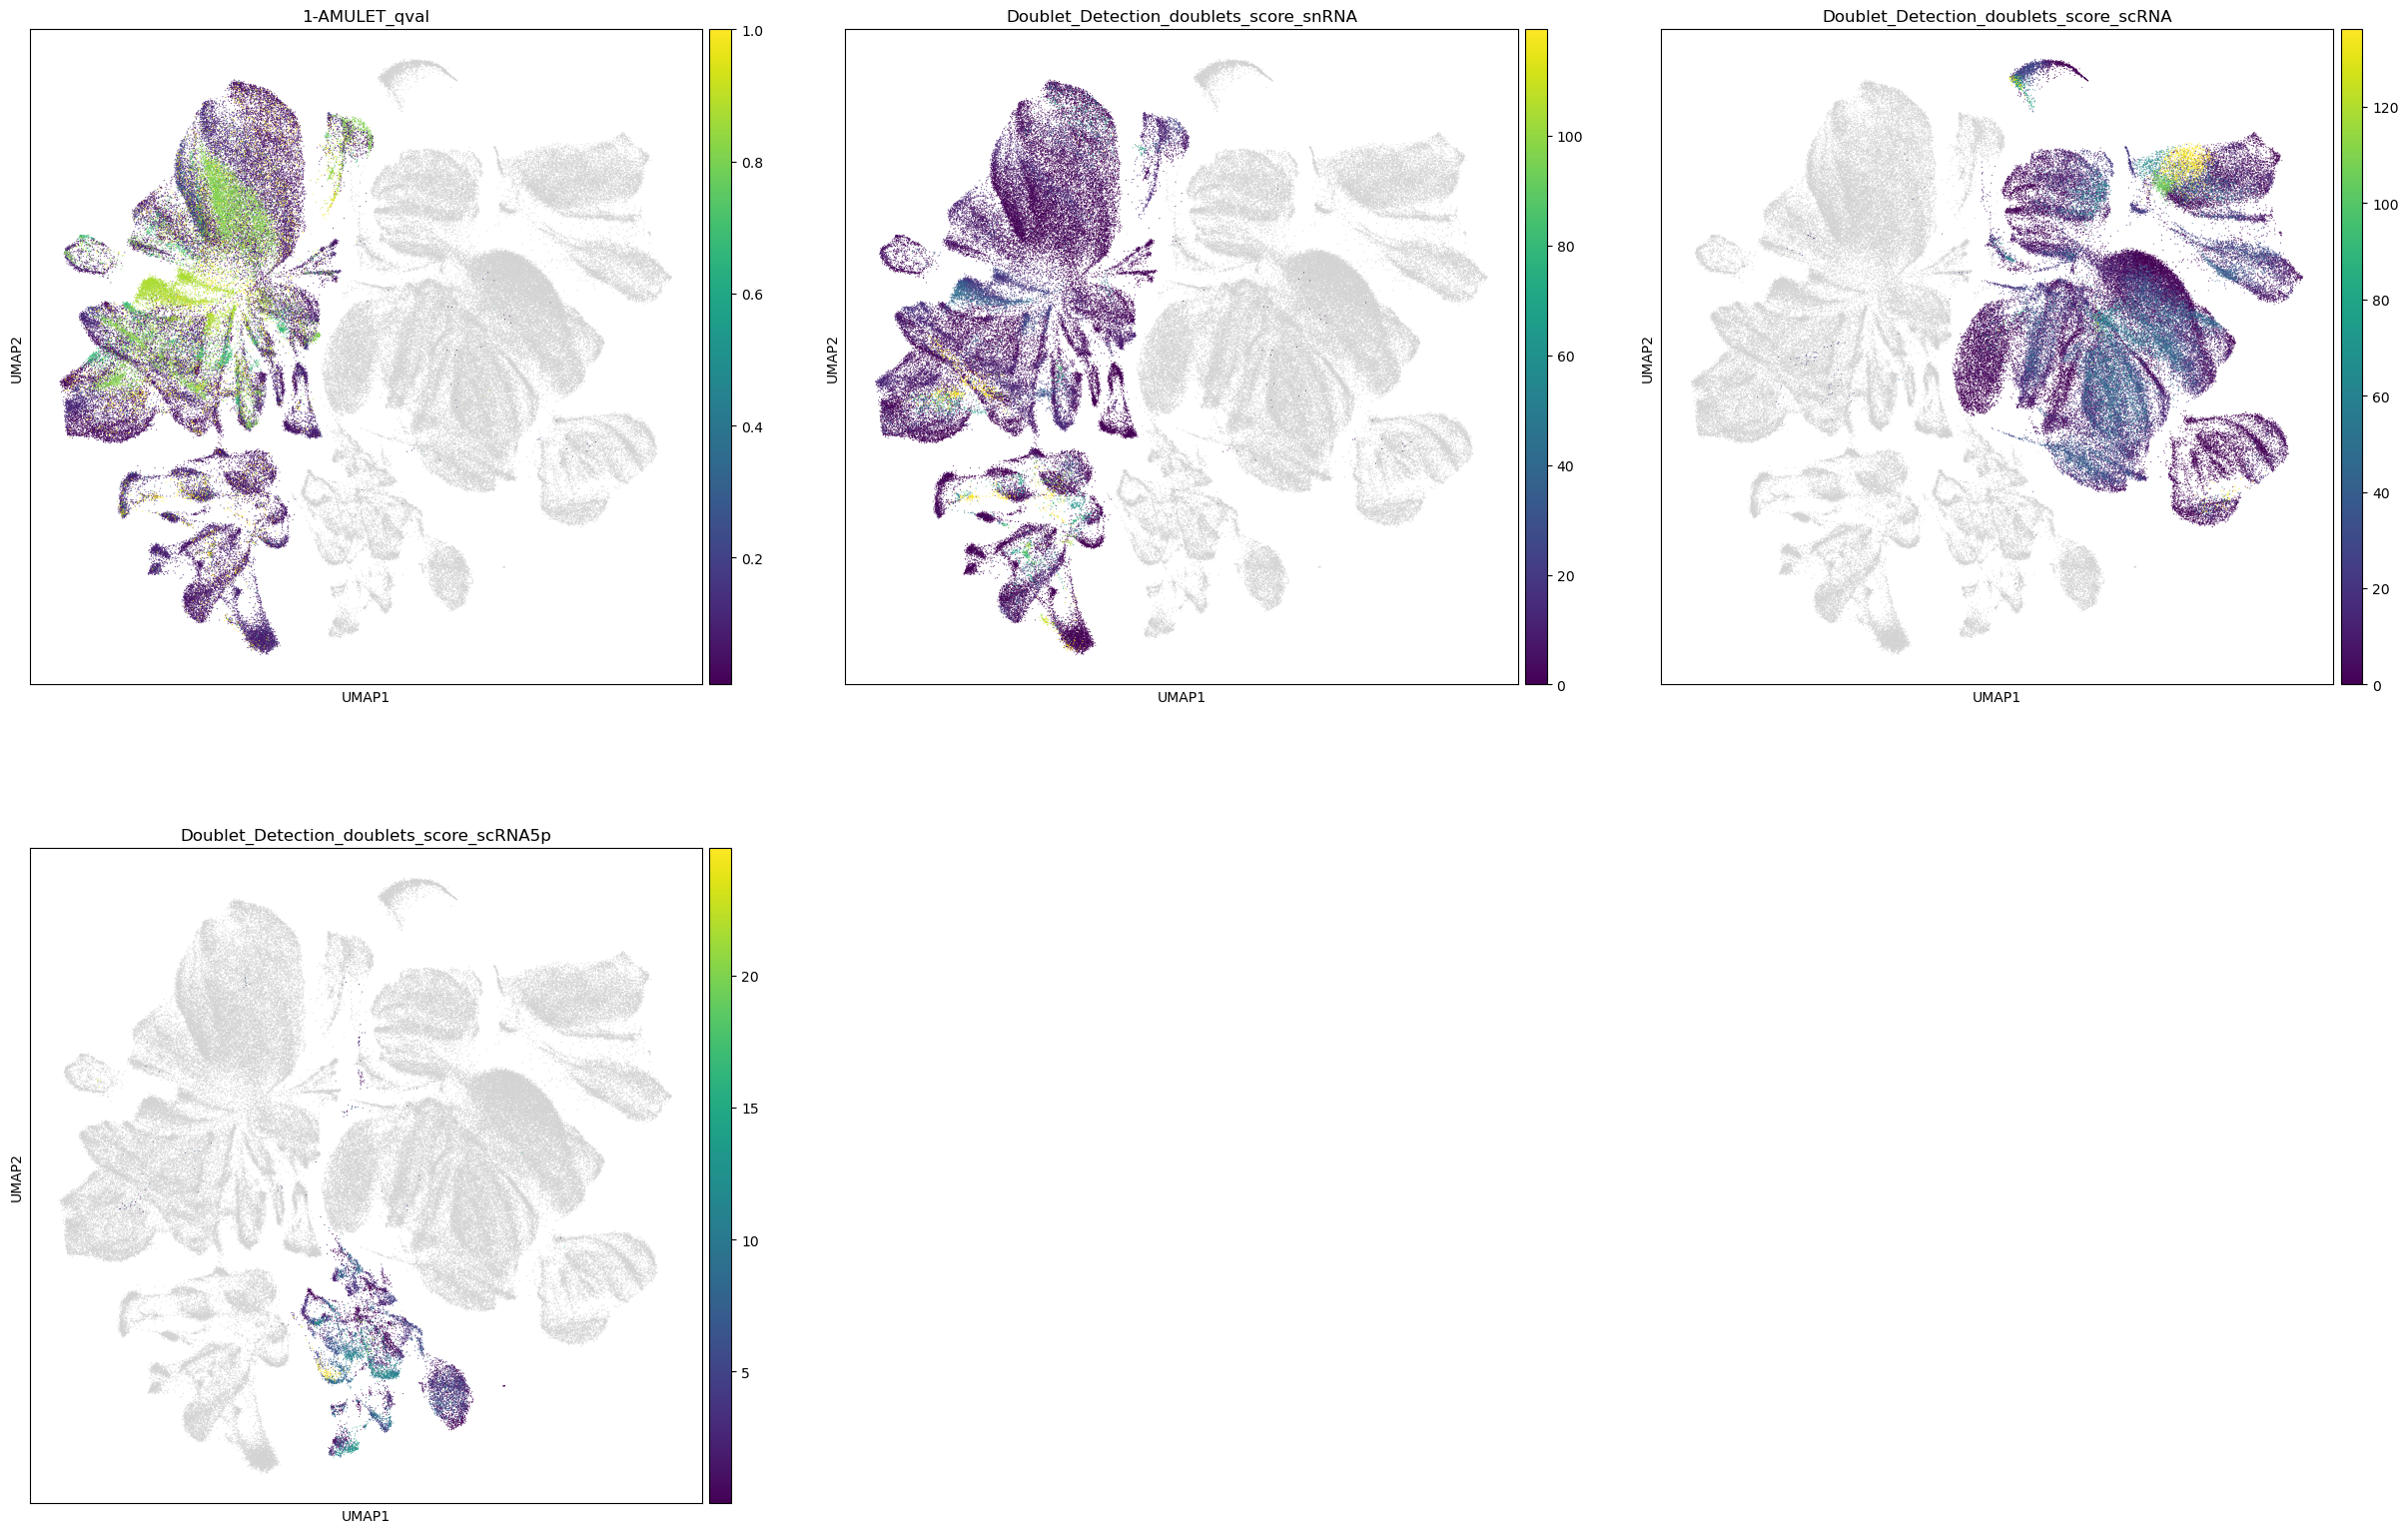

In [18]:
rcParams['figure.figsize'] = (9,9)
sc.pl.umap(adata, color = ['1-AMULET_qval','Doublet_Detection_doublets_score_snRNA','Doublet_Detection_doublets_score_scRNA','Doublet_Detection_doublets_score_scRNA5p'], size = 2, ncols=3, vmax='p99', groups=[True,'True'])

In [19]:
adata = adata[adata.obs['Doublet_Detection_doublets_snRNA'].isin([False]) & adata.obs['Doublet_Detection_doublets_scRNA'].isin([False]) & adata.obs['AMULET_doublets'].isin([False]) & ~adata.obs['Deepscore_external'].isin(['Unclassified'])].copy()

In [20]:
adata

AnnData object with n_obs × n_vars = 156541 × 38224
    obs: 'sample', 'batch', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Deepscore_external', 'Doublet_Detection_doublets_scRNA', 'Doublet_Detection_doublets_score_scRNA', 'Doublet_Detection_doublets_scRNA5p', 'Doublet_Detection_doublets_score_scRNA5p', 'AMULET_doublets', 'AMULET_pval', 'AMULET_qval', 'Doublet_Detection_doublets_snRNA', 'Doublet_Detection_doublets_score_snRNA', '1-AMULET_qval'
    uns: 'batch_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [14]:
adata.var

mt_rb     mt     rb  n_cells_by_counts  mean_counts  \
A1BG          False  False  False               5087     0.043296   
A1BG-AS1      False  False  False               1146     0.008460   
A1CF          False  False  False               9245     0.108089   
A2M           False  False  False              13858     0.336887   
A2M-AS1       False  False  False               1088     0.007736   
...             ...    ...    ...                ...          ...   
ZYG11B        False  False  False              27978     0.274048   
ZYX           False  False  False              10592     0.101408   
ZZEF1         False  False  False              26418     0.254884   
hsa-mir-1253  False  False  False                  0     0.000000   
hsa-mir-423   False  False  False                  0     0.000000   

              pct_dropout_by_counts  total_counts  
A1BG                      96.489521        6274.0  
A1BG-AS1                  99.209159        1226.0  
A1CF                      93.620134       15663.0  
A2M                       90.436757       48818.0  
A2M-AS1                   99.249184        1121.0  
...                             ...           ...  
ZYG11B                    80.692711       39712.0  
ZYX                       92.690585       14695.0  
ZZEF1                     81.769248       36935.0  
hsa-mir-1253             100.000000           0.0  
hsa-mir-423              100.000000           0.0  

[38233 rows x 7 columns]

In [ ]:
adata = adata[:,~adata.var['mt_rb']].copy() # Avoid the influence of MT and RB genes as possible counfounding factors

# GENE SELECTION

In [ ]:
# Provide the technology as batch labels
hvg_MOD = sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes= 5000, batch_key='batch',inplace=False, span=1)

In [ ]:
hvg_MOD= hvg_MOD[hvg_MOD['highly_variable']]

In [26]:
hvg = hvg_MOD[hvg_MOD['highly_variable']].index

In [27]:
len(hvg)

5000

In [29]:
adata.var['highly_variable'] = [var in hvg for var in adata.var.index]

In [2]:
import gdown
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
# from scvi.external import CellAssign

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be r

In [1]:
import umap

/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/marioam/miniconda3/envs/General_env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/marioam/miniconda3/envs/General_env/lib/python3.9/si

In [31]:
import torch

torch.cuda.is_available()

True

In [32]:
adata = adata[:, adata.var.highly_variable].copy()

In [33]:
adata

AnnData object with n_obs × n_vars = 156541 × 5000
    obs: 'sample', 'batch', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Deepscore_external', 'Doublet_Detection_doublets_scRNA', 'Doublet_Detection_doublets_score_scRNA', 'Doublet_Detection_doublets_scRNA5p', 'Doublet_Detection_doublets_score_scRNA5p', 'AMULET_doublets', 'AMULET_pval', 'AMULET_qval', 'Doublet_Detection_doublets_snRNA', 'Doublet_Detection_doublets_score_snRNA', '1-AMULET_qval', 'total_counts_mt_rb', 'pct_counts_mt_rb'
    var: 'mt_rb', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable'
    uns: 'batch_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
scvi.model.SCVI.setup_anndata(adata, batch_key='batch',categorical_covariate_keys=['sample'],)

scvi_model = scvi.model.SCVI(adata, n_latent=30, n_layers=3,)


In [35]:
scvi_model.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'batch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['sample'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   3    │
│         n_cells          │ 156541 │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  5000  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │   scRNA    │          0          │
│                    │   snRNA    │          1          │
│                    │  scRNA5p   │          2          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │   lib_03   │          0          │
│                     │   lib_09   │          1          │
│                     │   lib_10   │          2          │
│                     │   lib_15   │          3          │
│                     │   lib_16   │          4          │
│                     │   lib_19   │          5          │
│                     │   lib_20   │          6          │
│                     │   lib_23   │          7          │
│                     │   lib_29   │          8          │
│                     │   lib_34   │          9          │
│                     │   lib_36   │         10          │
│                     │   lib_38   │         11          │
│                     │   lib_49   │         12          │
│                     │   lib_51   │         13          │
│                     │   lib_55   │         14          │
│                     │   lib_56   │         15          │
│                     │   lib_57   │         16          │
│                     │   lib_68   │         17          │
│                     │  lib_420   │         18          │
│                     │  lib_776   │         19          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

In [36]:
scvi_model.train(max_epochs=2000, use_gpu=True, early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 560/2000:  28%|█████████████████████████▏                                                                | 560/2000 [6:51:54<17:39:11, 44.13s/it, v_num=1, train_loss_step=917, train_loss_epoch=892]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 885.373. Signaling Trainer to stop.


In [37]:
adata.write('objects/Integration_scVI.h5ad', compression='gzip')

In [38]:
scvi_model.save('models/Integrated_NEW', overwrite=True)

In [39]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

In [40]:
adata.write('objects/Integration_scVI.h5ad', compression='gzip')

In [3]:
adata = sc.read('objects/Integration_scVI.h5ad', compression='gzip')

In [5]:
scvi_model = scvi.model.SCVI.load('models/Integrated_NEW', adata = adata)

INFO     File models/Integrated_NEW/model.pt already downloaded                                                    


In [7]:
a = sc.AnnData(scvi_model.get_latent_representation())

In [8]:
del adata
del scvi_model

In [4]:
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=100)

In [5]:
sc.tl.umap(adata, spread = 2, min_dist = 0.1)

In [9]:
sc.tl.leiden(adata)

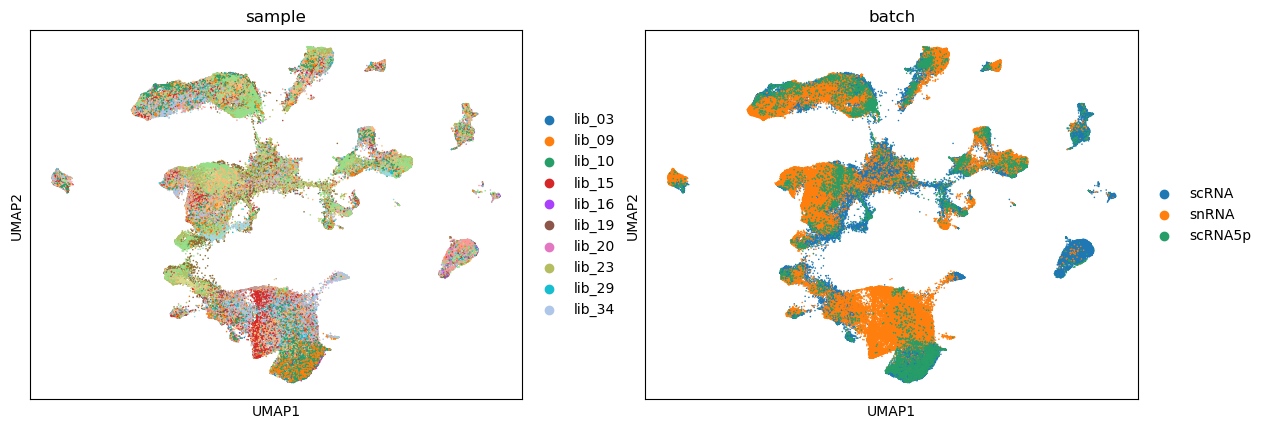

In [6]:
sc.pl.umap(adata, color = ['sample','batch'], size = 5)

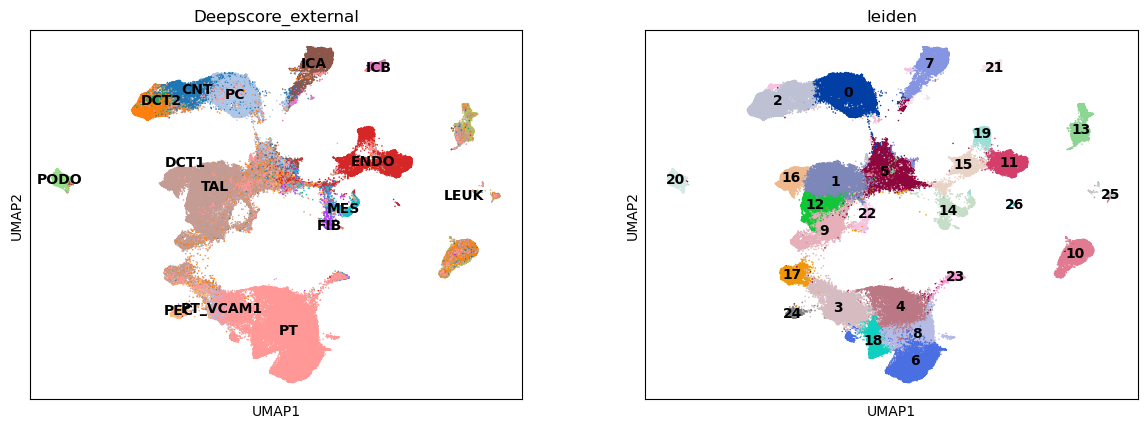

In [12]:
sc.pl.umap(adata, color = ['Deepscore_external', 'leiden'], size = 5, legend_loc='on data')

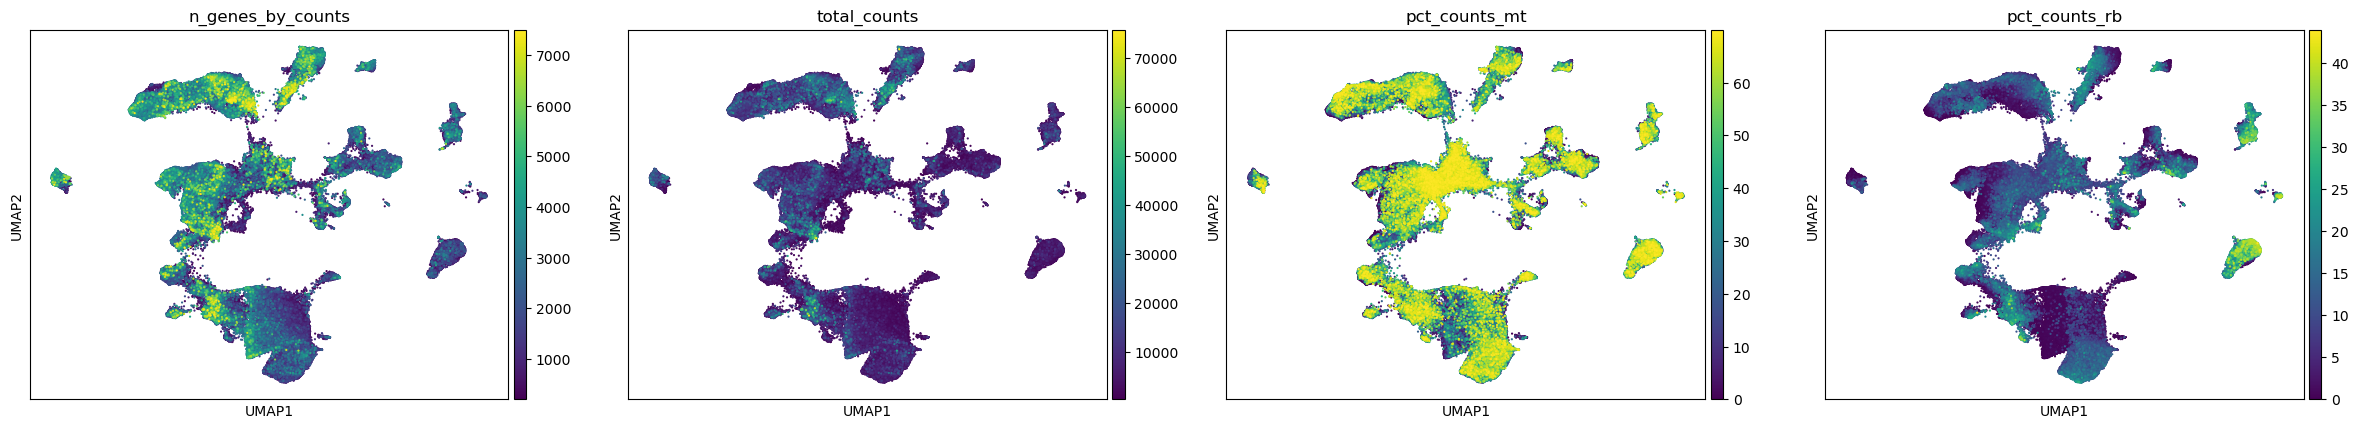

In [8]:
sc.pl.umap(adata, color = [ 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_rb'], size = 10)

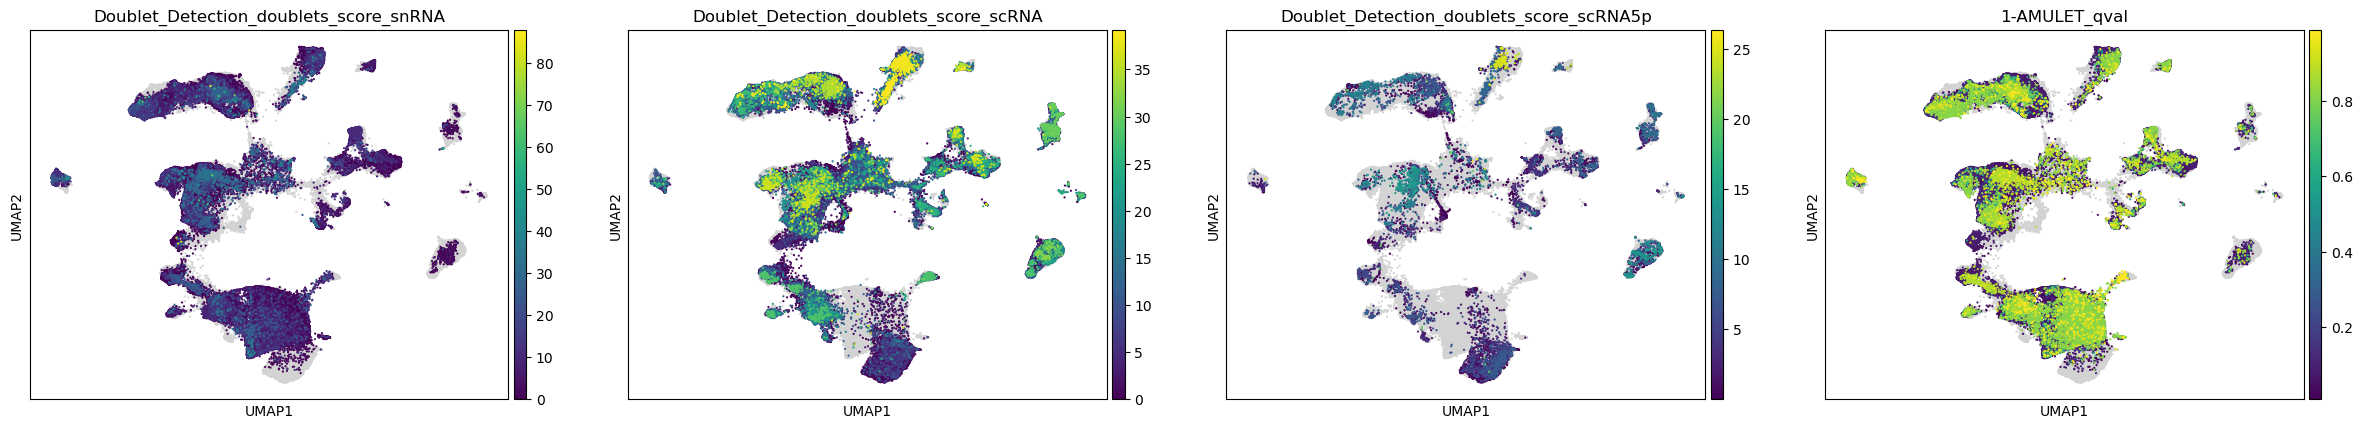

In [14]:
sc.pl.umap(adata, color = [ 'Doublet_Detection_doublets_score_snRNA', 'Doublet_Detection_doublets_score_scRNA', 'Doublet_Detection_doublets_score_scRNA5p', '1-AMULET_qval'], size = 10)

In [18]:
import numpy as np

In [36]:
adata = adata[~(adata.obs['sample'].isin(['lib_23','lib_38']) & adata.obs['batch'].isin(['snRNA'])) & ~(adata.obs['sample'].isin(['lib_776','lib_23']) & adata.obs['batch'].isin(['scRNA']))]

In [37]:
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=100)

In [38]:
sc.tl.umap(adata, spread = 2, min_dist = 0.1)

In [39]:
sc.tl.leiden(adata)

In [40]:
adata

AnnData object with n_obs × n_vars = 119171 × 5000
    obs: 'sample', 'batch', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Deepscore_external', 'Doublet_Detection_doublets_scRNA', 'Doublet_Detection_doublets_score_scRNA', 'Doublet_Detection_doublets_scRNA5p', 'Doublet_Detection_doublets_score_scRNA5p', 'AMULET_doublets', 'AMULET_pval', 'AMULET_qval', 'Doublet_Detection_doublets_snRNA', 'Doublet_Detection_doublets_score_snRNA', '1-AMULET_qval', 'total_counts_mt_rb', 'pct_counts_mt_rb', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'mt_rb', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap', 'Deepscore_external_colors', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    varm: 'PCs'
    layers:

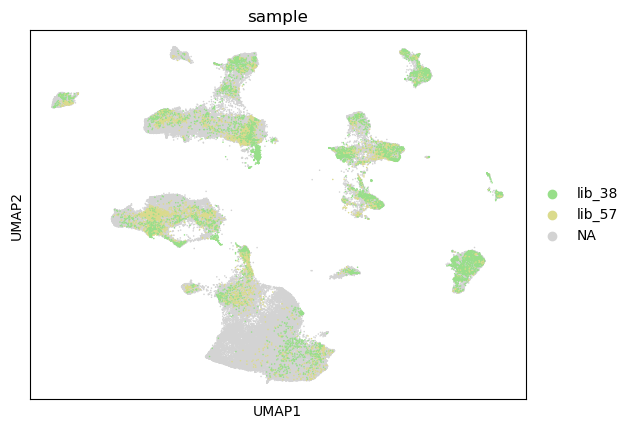

In [48]:
sc.pl.umap(adata, color = ['sample'], size = 5, groups = ['lib_57','lib_38'])

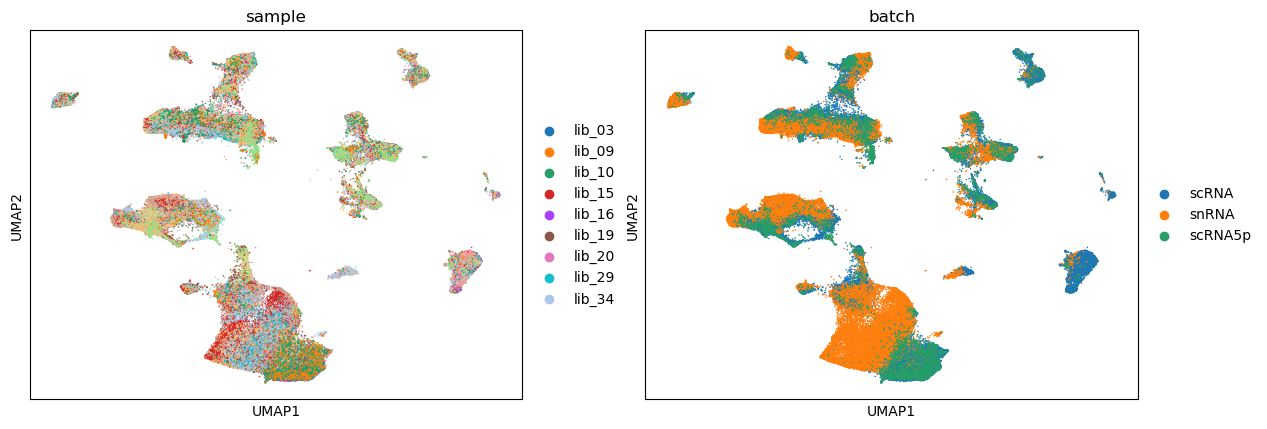

In [42]:
sc.pl.umap(adata, color = ['sample','batch'], size = 5)

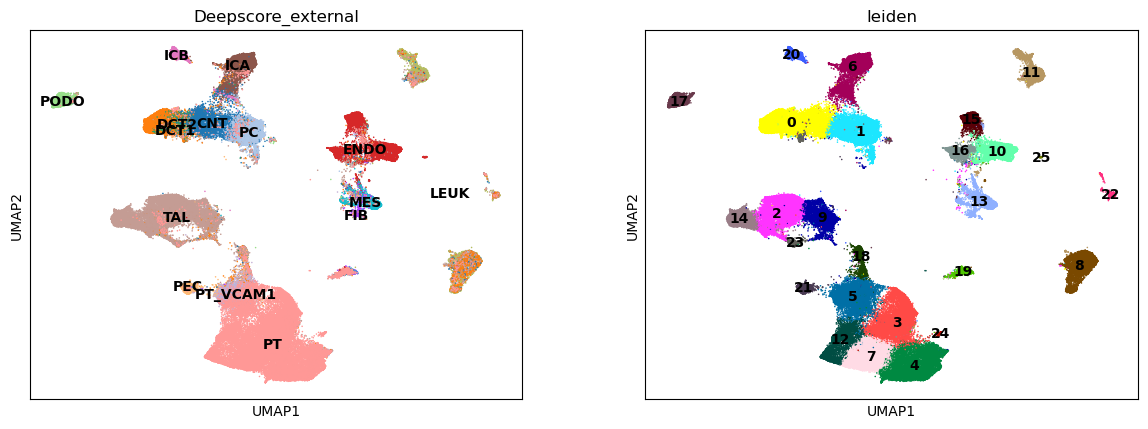

In [43]:
sc.pl.umap(adata, color = ['Deepscore_external', 'leiden'], size = 5, legend_loc='on data')

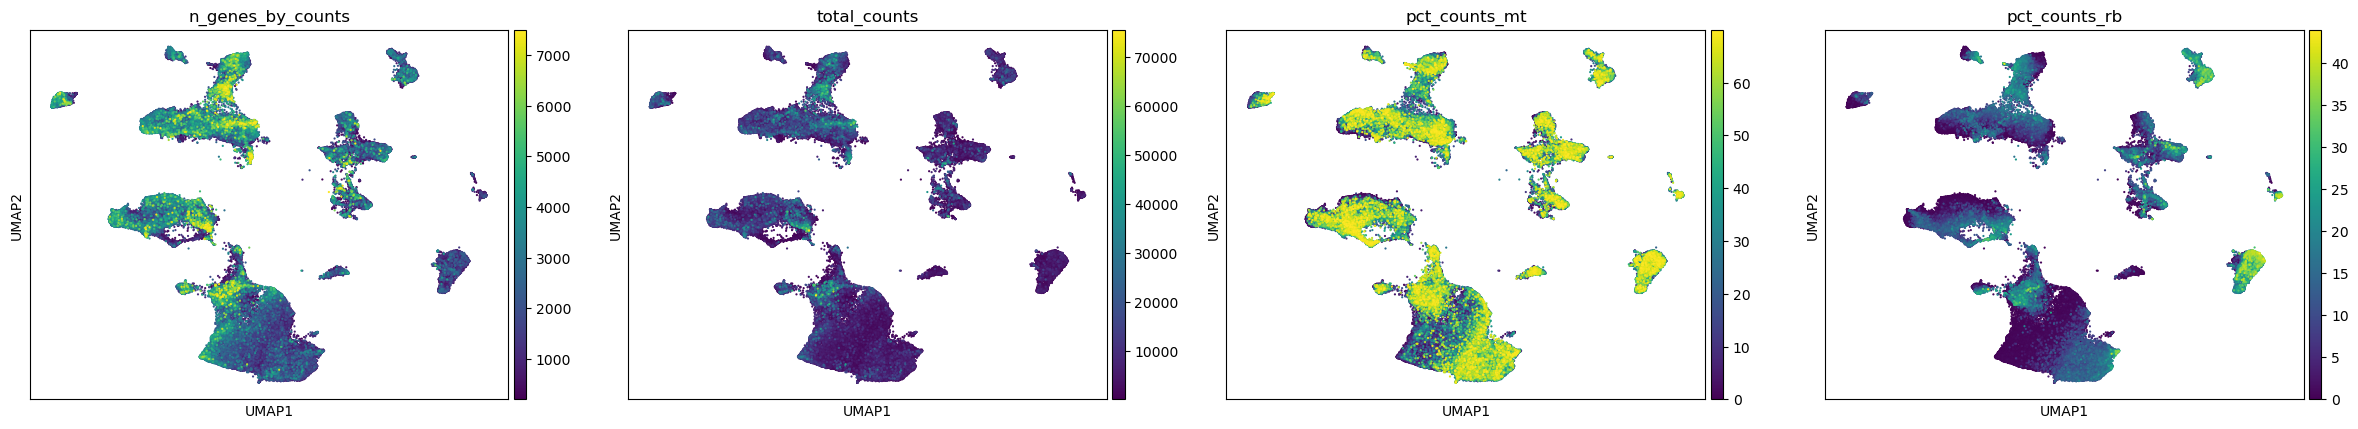

In [44]:
sc.pl.umap(adata, color = [ 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_rb'], size = 10)

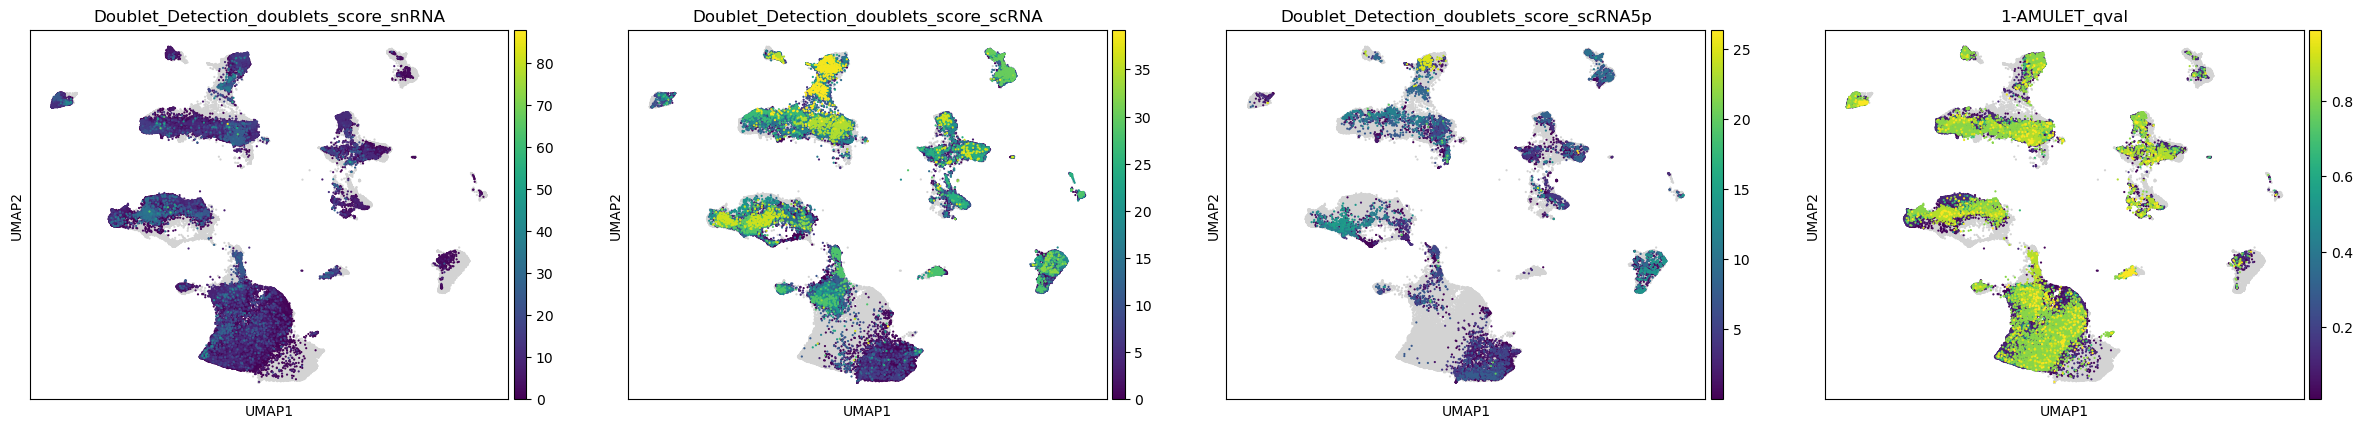

In [45]:
sc.pl.umap(adata, color = [ 'Doublet_Detection_doublets_score_snRNA', 'Doublet_Detection_doublets_score_scRNA', 'Doublet_Detection_doublets_score_scRNA5p', '1-AMULET_qval'], size = 10)

In [49]:
adata.write('objects/scRNA_snRNA_scRNA5p_Integration_scVI.h5ad', compression='gzip')